Данный файл содержит основные аналитические данные, которые использовались при обработке текстовых данных 
и их кластеризации по интересам.

Датасет, который используется ниже - информация о словах-интересах. была собрана со страниц вк 
(преимущественнно - люди, состоящие в мгту- и it-сообществах) из раздела 'мои интересы'
(несколько миллионов пользователей). после текстовой обработки осталось около 3.5К лемм-слов 
с рассчитаными для них векторами (с помощью преобученной RusVectores модели) и подсчетом частот слов.
 

Сразу же отсечем слова, которые нечасто использовались. скорее всего, это различные слова, 
слабо относящиеся к тематике интересов (что-нибудь вроде 'дуб, клен, ясень'). выведем топ популярных слов
(кто бы сомневался, что музыка будет на первом месте), а также построим распределение частот слов.

In [33]:
import pandas as pd
df = pd.read_csv("../data/interest_data/interest_dataset.csv", index_col=0)
df = df[df['frequency'] >= 100].reset_index().drop('index', axis=1)
print(df.info())
print(df.sort_values(by=['frequency'], ascending=False)[['word', 'frequency']])

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3663 entries, 0 to 3662
Columns: 302 entries, 0 to frequency
dtypes: float64(300), int64(1), object(1)
memory usage: 8.4+ MB
None
                     word  frequency
1659          музыка_NOUN     122229
2979           спорт_NOUN      60185
1464          любить_NOUN      57332
1208           книга_NOUN      51094
2513     путешествие_NOUN      37315
...                   ...        ...
2116        питомник_NOUN        100
280     бухгалтерский_ADJ        100
2525            пять_NOUN        100
1802            никак_ADV        100
1721  наставничество_NOUN        100

[3663 rows x 2 columns]


Text(0.5, 0.98, 'word frequency distribution')

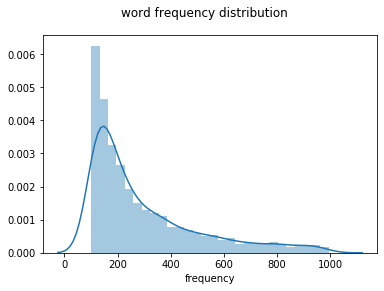

In [34]:
import seaborn as sns
sns_plot = sns.distplot(df[df['frequency'] < 1000]['frequency'])
fig = sns_plot.get_figure()
fig.suptitle('word frequency distribution')

Оценим разброс слов - снизим размерность слов-векторов до двух и отобразим на плоскости. 
Используется модель umap (https://habr.com/ru/company/newprolab/blog/350584/), 
которая имеет схожие с классическим t-SNE результаты, однако работает значительно быстрее. 
Как видно, данные явным образом не разбиваются на кластеры,  
однако топ слов достаточно равномерно распределен, что внушает оптимизм.

In [35]:
import umap     # faster than t-SNE, similar results
import numpy as np

np.random.seed(17)
um = umap.UMAP(metric='cosine', n_neighbors=15, init='random')
vectors_2dim = pd.DataFrame(um.fit_transform(df.drop(['word','frequency'], axis=1)))
print(vectors_2dim)

             0         1
0     3.877300  2.785488
1     6.405420  4.707420
2     4.201149  5.214722
3     3.466055  8.453095
4     0.234650  5.609462
...        ...       ...
3658  6.197912  6.085206
3659  6.287535  5.708654
3660  6.242494  5.635224
3661  3.787764  6.097588
3662  5.463772  4.470561

[3663 rows x 2 columns]


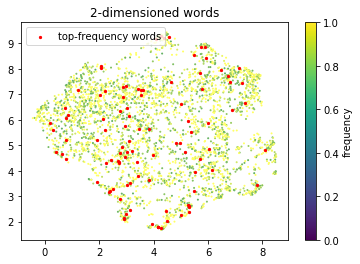

In [36]:
import matplotlib.pyplot as plt
from matplotlib import cm

plt.scatter(vectors_2dim[0], vectors_2dim[1], s=1, 
            c=df['frequency'].map(cm.summer))

best = df.sort_values(by=['frequency'], ascending=False).head(100).index
plt.scatter(vectors_2dim.iloc[best][0], vectors_2dim.iloc[best][1], s=5, 
            c='red', label='top-frequency words')

plt.title('2-dimensioned words')
plt.legend()
plt.colorbar(label='frequency')
plt.show()

Поработаем с весами слов. чрезмерно большие веса уникальны и могут испортить дальнейшую работу, 
поэтому обрежем их по пороговому значению в 2К  (около 1/5 всех слов скопилось на этом значении... 
но непосредственно в кластеризации веса роли не сыграют, посему ничего страшного).

word weight info:
min: 100
max: 2000
mean: 507.5858585858586


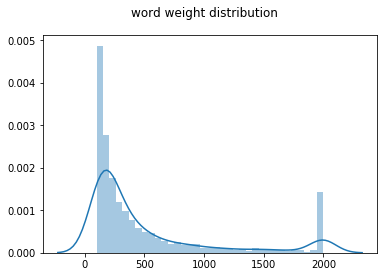

In [37]:
def print_info(which:str, arr):
    print(which, 'info:\nmin:', arr.min())
    print('max:', arr.max())
    print('mean:', arr.mean())
    
weights = np.array(df['frequency'])
weights = np.minimum(weights, 2000)
print_info('word weight', weights)
df['weight'] = weights

sns_plot = sns.distplot(weights)
fig = sns_plot.get_figure()
fig.suptitle('word weight distribution')
plt.show()

Построив распределение взаимных расстояний, обнаружим небольшую проблему - очень узкое распределение, 
большинство слов не так уж далеки друг от друга. это вызовет определенные проблемы с подбором алгоритма 
кластеризации, но лезть в word-embedding уже довольно поздно...

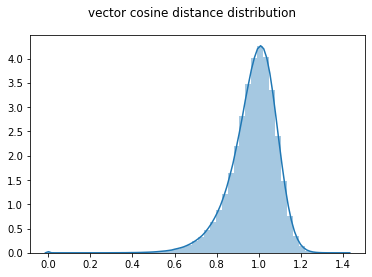

In [38]:
from sklearn.metrics.pairwise import cosine_distances
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
vectors = np.array(df.drop(['word', 'frequency', 'weight'], axis=1))

dist = np.hstack(cosine_distances(vectors, vectors))
#print_info('words mutual distance', dist)

sns_plot = sns.distplot(dist)
fig = sns_plot.get_figure()
fig.suptitle('vector cosine distance distribution')
plt.show()

Представленный ниже алгоритм превосходно справляется с поставленной задачей
(https://scikit-learn.org/stable/modules/generated/sklearn.cluster.AgglomerativeClustering.html). 
официальная документация гласит: 'algorithm recursively merges the pair of clusters
that minimally increases a given linkage distance.' Идеально. Мы потихоньку склеиваем слова, 
которые ближе всего по смыслу друг к другу, при этом имеем возможность задать пороговое значение, 
выше которого объединение кластеров не происходит. Было взято значение 0.6, что на графике выше 
соответствует выборке по довольно малому объему связей.... однако этого вполне хватило.

In [39]:
from sklearn.cluster import AgglomerativeClustering

model = AgglomerativeClustering(n_clusters=None, affinity='cosine',
                                distance_threshold=0.6, linkage='average')
model.fit(vectors)

predictions = model.labels_
df['class'] = predictions

После обучения мы получили около 1.5 тысяч кластеров. Однако, взглянув на распределение
размеров этих групп, становилась понятна причина - большинство кластеров имеют всего несколько
элементов. Это слова-выбросы, которые не имеют место (в большинстве своем) к основным группам
интересов (пропущенные местоимения, слова вроде 'который' и п

total cluster count: 1572
clusters with word-count >= 6 : 145
group weights:
 35     20200
116    19190
4      18920
52     14514
21     13673
       ...  
95      1234
78      1080
144     1077
39       917
91       863
Name: weight, Length: 145, dtype: int64


Text(0.5, 0.98, 'group size distribution')

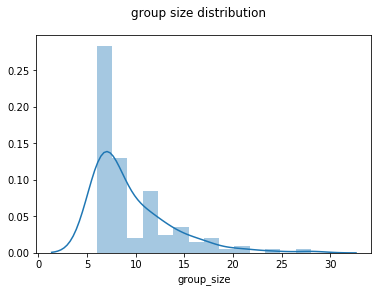

In [40]:
min_group_size = 6
unique, counts = np.unique(predictions, return_counts=True)
print('total cluster count:', len(unique))

groups = df.groupby('class').groups
groups = [[np.array(ids), len(ids)] for g, ids in groups.items() if len(ids) >= min_group_size]
groups = pd.DataFrame(groups, columns=['word_ids', 'group_size'])

print('clusters with word-count >=', min_group_size, ':', groups.shape[0])

groups['weight'] = [np.sum(df['weight'][ids]) for ids in groups.word_ids]
groups = groups.sort_values(by=['weight'], ascending=False)
print('group weights:\n', groups.weight)
groups = groups[:128].reset_index().drop('index', axis=1)

sns_plot = sns.distplot(groups['group_size'])
fig = sns_plot.get_figure()
fig.suptitle('group size distribution')

10 most frequent words are in 10 clusters
30 most frequent words are in 27 clusters
100 most frequent words are in 80 clusters


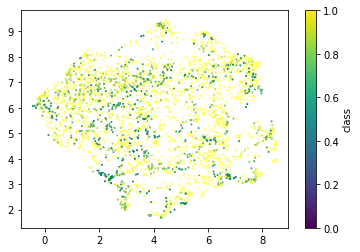

In [41]:
sorted_df = df.sort_values(by=['frequency'], ascending=False)
for n in [10, 30, 100]:
    print(n, 'most frequent words are in', len(np.unique(sorted_df.head(n)['class'])), 'clusters')

plt.scatter(vectors_2dim[0], vectors_2dim[1], s=1, 
            c=df['class'].map(cm.summer))
plt.colorbar(label='class')

В дальнейшем кластеры обрабатывались следующим образом: 
- из 145 найденных групп были выбраны 128 (из-за неимоверной красоты числа)
- для каждой группы интересов считался средний вектор ее элементов (взвешенное среднее арифм-е)
- также в каждой группе отбирались 3 самый частых слова, которые стали дескрипторами группы
  интересов (для простоты анализа полученных векторов для групп-постов-юзеров)

In [42]:
roof = 0.8
i = 0
df = df[df['frequency'] < 1000]
nv = df.shape[0]
nbs = [0]*nv
for x in range(nv):
    for _ in range(nv):
        if dist[i] < roof:
            nbs[x] += 1
        i += 1

print(nbs)
    

[58, 74, 56, 50, 94, 262, 33, 67, 49, 116, 212, 343, 340, 14, 383, 413, 359, 233, 121, 122, 220, 206, 244, 201, 194, 214, 401, 271, 480, 477, 311, 240, 106, 144, 253, 214, 236, 467, 499, 419, 174, 114, 116, 88, 125, 72, 185, 231, 188, 201, 221, 306, 180, 281, 431, 332, 190, 145, 317, 15, 414, 242, 168, 175, 249, 383, 273, 401, 282, 161, 91, 127, 77, 279, 236, 222, 244, 269, 447, 42, 154, 326, 445, 473, 297, 163, 458, 299, 193, 180, 190, 176, 55, 160, 235, 218, 137, 208, 569, 303, 274, 364, 394, 338, 401, 181, 250, 240, 372, 292, 90, 35, 99, 145, 141, 189, 167, 162, 8, 181, 237, 228, 182, 173, 228, 391, 412, 521, 536, 307, 136, 233, 305, 282, 277, 246, 248, 254, 127, 239, 118, 262, 391, 392, 307, 209, 202, 99, 254, 306, 158, 237, 141, 222, 206, 152, 221, 468, 148, 187, 157, 230, 333, 205, 225, 131, 59, 200, 216, 216, 230, 311, 143, 226, 228, 178, 208, 347, 126, 74, 109, 201, 270, 276, 193, 186, 135, 101, 97, 77, 46, 234, 132, 76, 53, 97, 250, 295, 73, 35, 83, 246, 292, 257, 54, 155, 177

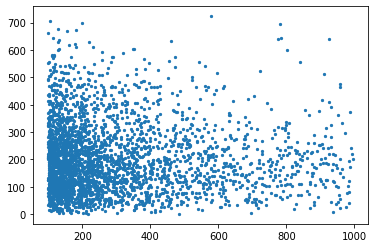

In [43]:
plt.scatter(x=df['frequency'], y=nbs, s=5)



In [51]:
all_grouped_ids = []
for i in range(groups.shape[0]):
    all_grouped_ids += list(groups['word_ids'][i])
    
print(len(all_grouped_ids), nv)


1216 3108
